## Task 2.4: Optimize Buffer drive amplitude (ε_d) in Hamiltonian

### We chose Buffer drive amplitude (ε_d) as a easy parameter in H to change and optimize
We randomly generate Buffer drive amplitude (ε_d) and save the best value.

Import Dependencies

In [6]:
import dynamiqs as dq
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import random

Define system parameters

In [7]:
GHz = 1.0
MHz = 1e-3 * GHz
kHz = 1e-3 * MHz

omega_a_0 = 5.26 * GHz
omega_b_0 = 7.70 * GHz
phi_a = 0.06
phi_b = 0.29
E_J = 12.03 * GHz
delta_E_J = 0.47 * GHz
omega_d = 7.623 * GHz
omega_p = 2.891 * GHz

Buffer drive amplitude (ε_d)

In [8]:
# Generate random values of ε_d
num_samples = 20  # Number of random trials
epsilon_d_values = [random.uniform(-5.0, -2.0) * MHz for _ in range(num_samples)]

Dissipation rates

In [9]:
kappa_a = 9.3 * kHz
kappa_b = 2.6 * MHz

Define Hilbert space

In [10]:
n_fock_a = 20  # Memory mode
n_fock_b = 5   # Buffer mode

In [12]:
a = dq.tensor(dq.destroy(n_fock_a), dq.eye(n_fock_b))
b = dq.tensor(dq.eye(n_fock_a), dq.destroy(n_fock_b))

Identity operator

In [13]:
identity = dq.tensor(dq.eye(n_fock_a), dq.eye(n_fock_b))

Time range for simulation

In [14]:
t = jnp.linspace(0, 4, 100)

Loop through different values of ε_d

In [ ]:
best_params = []

alpha_target = np.sqrt(5.0)  # Target amplitude of the cat state
target_photon_number = alpha_target**2

for eps_d in epsilon_d_values:
    # Define Hamiltonian with updated ε_d
    H = omega_a_0 * a.dag() @ a + omega_b_0 * b.dag() @ b + eps_d * (b + b.dag())
    
    # Solve for this ε_d
    res = dq.mesolve(H, [jnp.sqrt(kappa_b) * b, jnp.sqrt(kappa_a) * a], dq.coherent((n_fock_a, n_fock_b), [0, 0]), t)
    rho_a = dq.ptrace(res.states, 0)
    
    parity_op = dq.parity(n_fock_a)  

    # Compute photon expectation and parity
    photon_expectation = [dq.expect(parity_op, rho) for rho in rho_a]
    parity_values = [dq.expect(parity_op, rho) for rho in rho_a]

    # Define stability criteria
    stability_criteria = np.std(photon_expectation[-10:]) < 0.1 

    # If stable, save the ε_d value
    if stability_criteria:
        best_params.append((eps_d, np.mean(photon_expectation[-10:])))

# Sort by most stable result
best_params.sort(key=lambda x: abs(x[1] - target_photon_number))

# Print best ε_d values
print("Best ε_d values:", best_params)

100%|██████████| 50/50 [00:03<00:00, 12.68it/s]


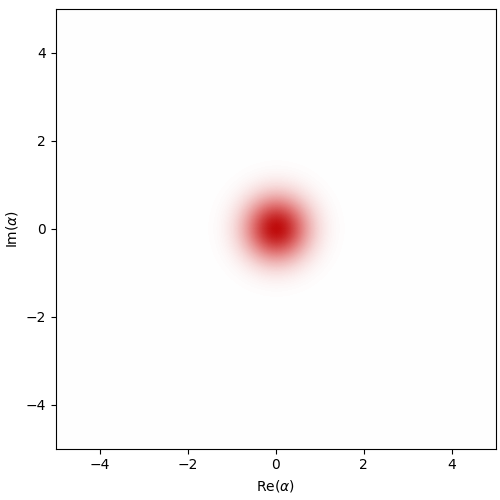

In [16]:
dq.plot.wigner_gif(rho_a)

In [ ]:
photon_number_op = dq.destroy(n_fock_a).dag() @ dq.destroy(n_fock_a)  
photon_expectation = [dq.expect(photon_number_op, rho) for rho in rho_a] 

/Users/mimo/LocalDocuments/git/2025-Alice-and-Bob/env/lib/python3.10/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=complex64 to dtype=float32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
/Users/mimo/LocalDocuments/git/2025-Alice-and-Bob/env/lib/python3.10/site-packages/jax/_src/ops/scatter.py:136: ComplexWarning: Casting complex values to real discards the imaginary part
  return lax_internal._convert_element_type(out, dtype, weak_type)


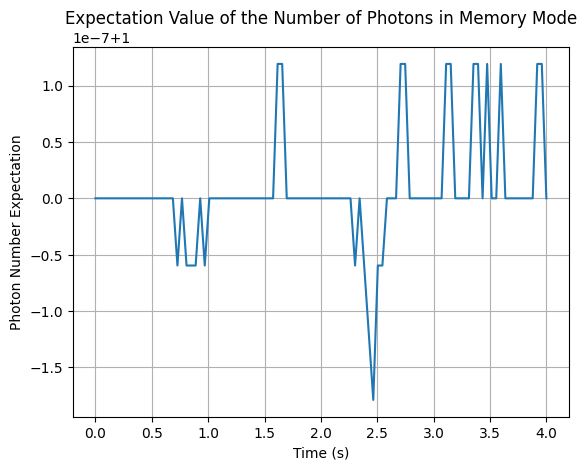

In [23]:
# Plot the expectation value of the number of photons in the memory mode
a_op = dq.destroy(n_fock_a)
num_op_a = a_op @ a_op.dag()
size = len(rho_a)
photon_expect = jnp.zeros(size)
for i in range(size):
    val = dq.expect(num_op_a, rho_a[i])
    photon_expect = photon_expect.at[i].set(val)

plt.plot(t, photon_expect)
plt.xlabel("Time (s)")
plt.ylabel("Photon Number Expectation")
plt.title("Expectation Value of the Number of Photons in Memory Mode")
plt.grid()
plt.show()

/Users/mimo/LocalDocuments/git/2025-Alice-and-Bob/env/lib/python3.10/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=complex64 to dtype=float32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
/Users/mimo/LocalDocuments/git/2025-Alice-and-Bob/env/lib/python3.10/site-packages/jax/_src/ops/scatter.py:136: ComplexWarning: Casting complex values to real discards the imaginary part
  return lax_internal._convert_element_type(out, dtype, weak_type)


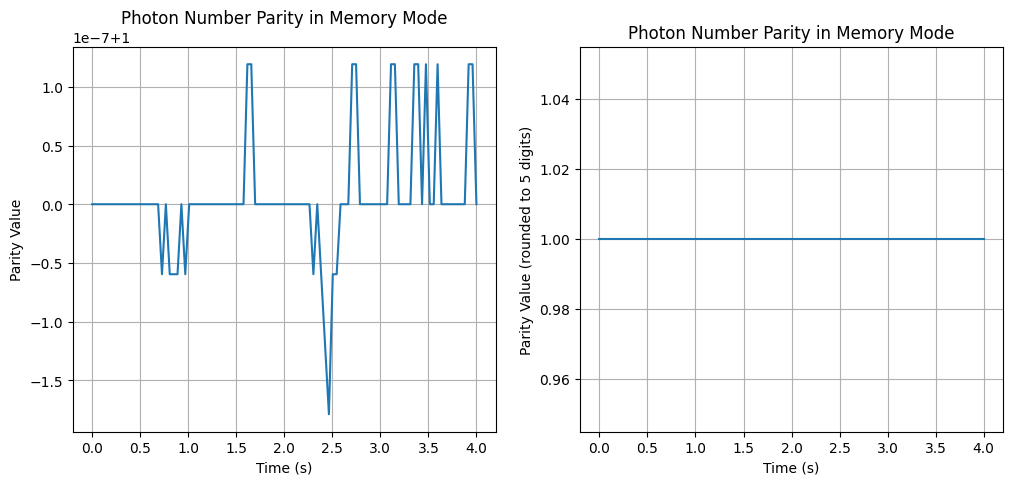

In [24]:
# Plot the photon number parity in the memory mode

# Define parity operator for memory mode
parity_op = dq.parity(n_fock_a)  

# Calculate the parity values for each time step
size = len(rho_a)
parity_val = jnp.zeros(size)
for i in range(size):
    val = dq.expect(parity_op, rho_a[i])
    parity_val = parity_val.at[i].set(val)

parity_val_rounded = np.round(parity_val, 5)

fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].plot(t, parity_val)
ax[1].plot(t, parity_val_rounded)
ax[0].set_xlabel("Time (s)")
ax[0].set_ylabel("Parity Value")
ax[0].set_title("Photon Number Parity in Memory Mode")
ax[1].set_xlabel("Time (s)")
ax[1].set_ylabel("Parity Value (rounded to 5 digits)")
ax[1].set_title("Photon Number Parity in Memory Mode")
ax[0].grid()
ax[1].grid()
plt.show()